# Plot F-layer figures

This notebook makes the final two figures form the manuscript and part of the first figure. It does this by processing output files from a large batch of runs.

In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import plotting
import bulk_case_runner

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/var/folders/j_/przs7cfj1b7czhv250v8t_440000gn/T/ipykernel_76783/2049638497.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Process all slurry cases and report basic information

We've run a grid of different $\Delta T_{ICB}$, $\Delta X_{ICB}$, $I_0$, $D_L$ and $\mu$
so our first step is to find the $\Delta T_{ICB}$ and $\Delta X_{ICB}$ that give
6 TW of heat production and 27 kg/m^3 of densitiy difference compared to the adiabat
for each set fixed $I_0$, $D_L$ and $\mu$. Not all choices of these parameters produce
'viable' models.

In [2]:
target_density_excess = 27.24 # This is prem - ak135f
target_latent_heat = 6.0*1.0E12 # W ... see arguments in manuscript

basepath = pathlib.Path('/Users/andreww/code/new_slurry_cases/')
filename = "grid.csv"

In [3]:


red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

# Dimond - high nuc rate
# Circle - med nuc rate
# square - low nuc rate

data = [{'dir': 'i0_1E-11_dl_1E-11_mu_3E-5',
         'color': red, 'm': 's', 'desc': 'red square'},
        {'dir': 'i0_1E-7_dl_1E-11_mu_3E-5',
         'color': red, 'm': 'D', 'desc': 'red diamond'},
        {'dir': 'i0_1E-9_dl_1E-11_mu_3E-5',
         'color': red, 'm': 'o', 'desc': 'red circle'},
        {'dir': 'i0_1E-11_dl_1E-11_mu_6E-8',
         'color': orange, 'm': 's', 'desc': 'orange square'},
        {'dir': 'i0_1E-7_dl_1E-11_mu_6E-8',
         'color': orange, 'm': 'D', 'desc': 'orange diamond'},
        {'dir': 'i0_1E-9_dl_1E-11_mu_6E-8',
         'color': orange, 'm': 'o', 'desc': 'orange circle'},
        {'dir': 'i0_1E-11_dl_1E-11_mu_2E-6',
         'color': yellow, 'm': 's', 'desc': 'yellow square'},
        {'dir': 'i0_1E-7_dl_1E-11_mu_2E-6',
         'color': yellow, 'm': 'D', 'desc': 'yellow diamond'},
        {'dir': 'i0_1E-9_dl_1E-11_mu_2E-6',
         'color': yellow, 'm': 'o', 'desc': 'yellow circle'},
        {'dir': 'i0_1E-11_dl_1E-9_mu_2E-6',
         'color': light_blue, 'm': 's', 'desc': 'light blue square'},
        {'dir': 'i0_1E-7_dl_1E-9_mu_2E-6',
         'color': light_blue, 'm': 'D', 'desc': 'light blue diamond'},
        {'dir': 'i0_1E-9_dl_1E-9_mu_2E-6',
         'color': light_blue, 'm': 'o', 'desc': 'light blue circle'},
        {'dir': 'i0_1E-11_dl_1E-12_mu_2E-6',
         'color': dark_blue, 'm': 's', 'desc': 'dark blue square'},
        {'dir': 'i0_1E-7_dl_1E-12_mu_2E-6',
         'color': dark_blue, 'm': 'D', 'desc': 'dark blue diamond'},
        {'dir': 'i0_1E-9_dl_1E-12_mu_2E-6',
         'color': dark_blue, 'm': 'o', 'desc': 'dark blue circle'}]

all_matches = None # Dataframe if we get a crossing
fallback_case = 'case_-50.0_0.0125.pkl' # for extra data even if no match
all_cases = [] # Will be a dataframe for reporting as LaTeX table

for thisdata in data:
    print(thisdata["dir"])
    summary_file = basepath / thisdata["dir"] / filename
    summary_df = pd.read_csv(summary_file)
    
    lx, lt = plotting._get_dt_dx_both(summary_df, target_latent_heat=target_latent_heat, 
                            target_density_excess=target_density_excess)
    print("Best x:", lx, "best T:", lt)
    match = summary_df[(summary_df["dt"] == lt) & 
                       (summary_df["dx"] == lx)].copy()
    latent_heat = match["total_latent_heat"].values[0] / 1.0E12 # TW
    excess_density = match.liquid_density_excess.values[0] + \
        match.max_solid_excess_density.fillna(0).values[0]
    print(f"Latent heat: {latent_heat} TW")
    print(f"Excess density: {excess_density} kg m^-3")
    if ((abs(excess_density - target_density_excess) < 2.0) and 
        (abs(latent_heat - target_latent_heat) < 6.0E12) and
        (latent_heat > 1.0)):
        print("OK")
        match["color"] = thisdata["color"]
        match["marker"] = thisdata["m"]
        full_file = basepath / thisdata["dir"] / f"detailed_output/case_{lt}_{lx}.pkl"
        match["full_file"] = str(full_file)
        match["summary_file"] = str(summary_file)
        detailed_data = bulk_case_runner.load_case_data(full_file)
        eta = detailed_data["kinematic_viscosity"]
        dl = detailed_data["chemical_diffusivity"]
        i0 = detailed_data["i0"]
        all_cases.append({'$D^L$': dl, '$\eta^L$': eta, '$I_0$': i0, 
                          '$\Delta T_{ICB}$': lt, '$\Delta X_{ICB}$': lx,
                          '$G_{ICB}': detailed_data["growth_rate"], 
                          '$\max r_p$': np.nanmax(detailed_data["particle_radii"]),
                          '$\max I$': np.nanmax(detailed_data["nucleation_rates"]),
                          '$\max \phi$': np.nanmax(detailed_data["solid_vf"]),
                          'Symbol': thisdata["desc"]})
        if all_matches is None:
            all_matches = match
        else:
            all_matches = pd.concat([all_matches,match])
            
    else:
        print("NOT OK")
        # We can always read input parameters from here...
        fallback_file = basepath / thisdata["dir"] / "detailed_output/case_-50.0_0.0125.pkl"
        detailed_data = bulk_case_runner.load_case_data(fallback_file)
        eta = detailed_data["kinematic_viscosity"]
        dl = detailed_data["chemical_diffusivity"]
        i0 = detailed_data["i0"]
        all_cases.append({'$D^L$': dl, '$\eta^L$': eta, '$I_0$': i0, 
                          '$\Delta T_{ICB}$': '--', '$\Delta X_{ICB}$': '--',
                          '$G_{ICB}': '--', '$\max r_p$': '--',
                          '$\max I$': '--', '$\max \phi$': '--', 'Symbol': thisdata["desc"]})
    
all_matches
print(pd.DataFrame(all_cases).to_latex(float_format="%.3g"))

i0_1E-11_dl_1E-11_mu_3E-5
Best x: 0.00625 best T: -65.0
Latent heat: 0.12416835182339296 TW
Excess density: 26.278166164554932 kg m^-3
NOT OK
i0_1E-7_dl_1E-11_mu_3E-5
Best x: 0.01 best T: 50.0
Latent heat: 6.054996732567291 TW
Excess density: 26.594680545871597 kg m^-3
OK
i0_1E-9_dl_1E-11_mu_3E-5
Best x: 0.008125 best T: -20.0
Latent heat: 6.004454838368143 TW
Excess density: 27.695933944100034 kg m^-3
OK
i0_1E-11_dl_1E-11_mu_6E-8
Best x: 0.00625 best T: -65.0
Latent heat: 0.9994313452695192 TW
Excess density: 26.278166177755338 kg m^-3
NOT OK
i0_1E-7_dl_1E-11_mu_6E-8
Best x: 0.01 best T: 45.0
Latent heat: 6.376931127779897 TW
Excess density: 27.098904346708878 kg m^-3
OK
i0_1E-9_dl_1E-11_mu_6E-8
Best x: 0.00875 best T: 10.0
Latent heat: 5.541704287254314 TW
Excess density: 26.657045820777057 kg m^-3
OK
i0_1E-11_dl_1E-11_mu_2E-6
Best x: 0.00625 best T: -65.0
Latent heat: 0.09390663419844204 TW
Excess density: 26.278166149268145 kg m^-3
NOT OK
i0_1E-7_dl_1E-11_mu_2E-6
Best x: 0.01 best 

## First, the summary plot...

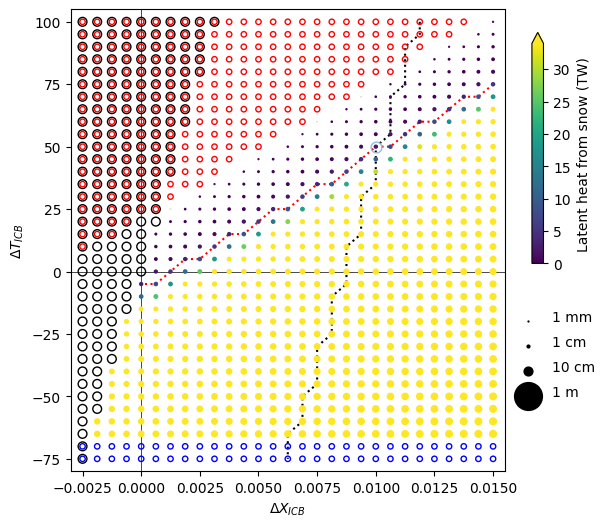

In [4]:
case = all_matches.loc[(all_matches['color'] == light_blue) & (all_matches['marker'] <= 'o')]

summary_file_name = case["summary_file"].values[0]
summary_df = pd.read_csv(summary_file_name)

# Get best latent heat and temperature on grid
lx, lt = plotting._get_dt_dx_both(summary_df, target_latent_heat=target_latent_heat, 
                            target_density_excess=target_density_excess)

# Make the plot
plotting.plot_summary_figure(summary_df, target_latent_heat=target_latent_heat, 
                    target_density_excess=target_density_excess, marker_x=lx,
                    marker_t=lt, marker=case["marker"].values[0], marker_color=case["color"].values[0])




In [5]:
case["marker"].values[0]

'o'

In [6]:
case["color"].values[0]

'#91bfdb'

## Plot the (input) temperature and composition profiles 

This *should* be the optimum location, but currently do not get access to this.

BV freq = 0.00022590837386311853
Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2
Temperature at CMB: 1565.182533320388 K
Liquid density at ICB: 12792.534318523183 Kg/m^3
Liquid density at top of F-layer 12542.509302676566 Kg/m^3
Liquid density along adiabat at ICB: 12764.931169768386 Kg/m^3
Liquid density along adiabat at top of F-layer 12571.912798104033 Kg/m^3
Liquid density difference at ICB: 27.603148754797076 Kg/m^3


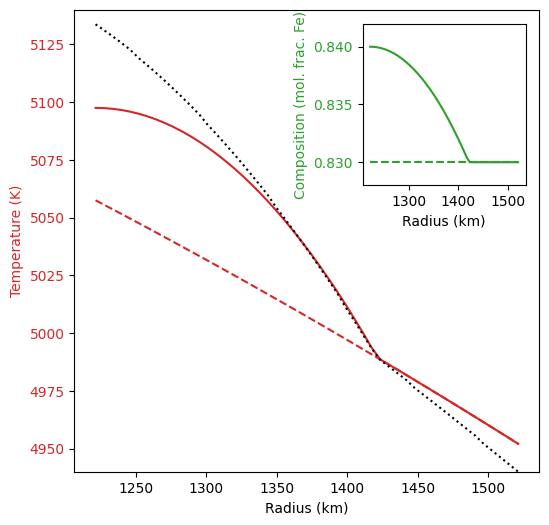

In [7]:
plotting.make_layer_plot(40, 0.01, 0.83)

## Finally - the detailed plot

This should also come from the crossing point.

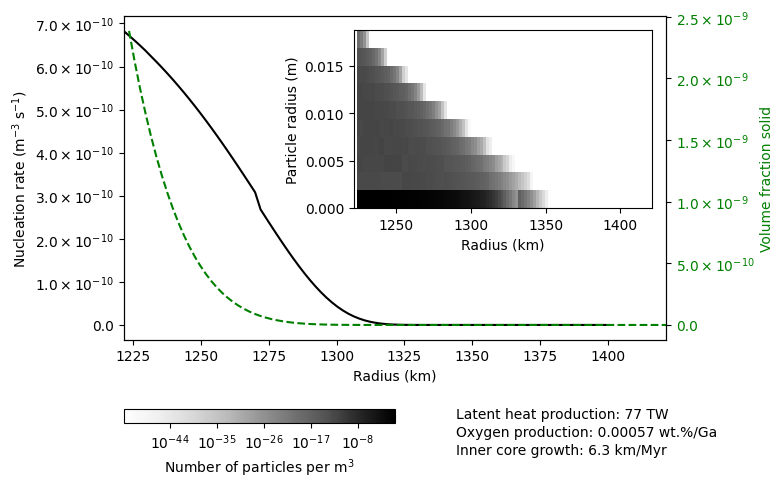

In [8]:
# Light blue circle for paper

file = '/Users/andreww/code/new_slurry_cases/i0_1E-9_dl_1E-9_mu_2E-6/detailed_output/case_35.0_0.01.pkl'
data = bulk_case_runner.load_case_data(file)
plotting.plot_case_figure(data)